# Integration with pandas

> Objectives:
> * Use pandas.HDFStore for serializing/deserializing pandas dataframes in HDF5 files
> * Compare in-memory queries (via pandas dataframes) with on-disk ones (via HDFStore)
> * Apply this to visualizing pokemons in Barcelona, New York and more!

Let's see how HDF5 integrates with pandas while we are having fun visualizing the different kinds of pokemons in different geographical areas (like, yeah, Barcelona).  The dataset that we will be using here can obtained from https://www.kaggle.com/semioniy/predictemall.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
import shutil

matplotlib.rcParams.update({'font.size': 12})

## Load the pokemon dataset

In [3]:
%%time
df = pd.read_csv('pokemon/300k_csv.zip')
# Replace ? by a float representation
df['pokestopDistanceKm'].replace({'?': -999.9}, inplace=True)
df['pokestopDistanceKm'] = df.pokestopDistanceKm.astype(float)
# Rename column with reserved name class by target
df.rename(columns={'class': 'target'}, inplace=True)

<string>:2: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 11.5 s, sys: 581 ms, total: 12 s
Wall time: 12.1 s


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296021 entries, 0 to 296020
Columns: 208 entries, pokemonId to target
dtypes: bool(168), float64(8), int64(17), object(8), uint64(7)
memory usage: 137.8+ MB


In [5]:
df.head()

pokemonId   latitude   longitude    appearedLocalTime  \
0         16  20.525745  -97.460829  2016-09-08T03:57:45   
1        133  20.523695  -97.461167  2016-09-08T03:57:37   
2         16  38.903590  -77.199780  2016-09-08T03:57:25   
3         13  47.665903 -122.312561  2016-09-08T03:56:22   
4        133  47.666454 -122.311628  2016-09-08T03:56:08   

                            _id           cellId_90m          cellId_180m  \
0  NTgxMDkzOTk4MTM5MjUwMjIzNw==  9645139108510564000  9645139108711890000   
1  OTQ1NDgzODc1MjM3NDEzMTI2MQ==  9645139109852742000  9645139109785633000   
2  NTQ0OTQ0NDA1Nzg2ODg3OTg2OQ==  9923201472785285000  9923201472986612000   
3  NTU2MTU1NDM4NzA2MDk1MDcxNw==  6093392705025474600  6093392705092583400   
4  MTY2ODg4MTAzMTczMDE0MTUwNTM=  6093392707709829100  6093392707776938000   

           cellId_370m          cellId_730m         cellId_1460m   ...    \
0  9645139108443455000  9645139109517197000  9645139113812165000   ...     
1  9645139110590940000  9645139109517197000  9645139113812165000   ...     
2  9923201473791918000  9923201477013144000  9923201481308110000   ...     
3  6093392705897889800  6093392702676664300  6093392715561566200   ...     
4  6093392708045373400  6093392711266598900  6093392715561566200   ...     

   cooc_143  cooc_144 cooc_145  cooc_146  cooc_147 cooc_148  cooc_149  \
0     False     False    False     False     False    False     False   
1     False     False    False     False     False    False     False   
2     False     False    False     False     False    False     False   
3     False     False    False     False     False    False     False   
4     False     False    False     False     False    False     False   

   cooc_150  cooc_151  target  
0     False     False      16  
1     False     False     133  
2     False     False      16  
3     False     False      13  
4     False     False     133  

[5 rows x 208 columns]

## Storing in HDF5 compressed form with pandas.HDFStore

Let's store the dataframe in HDF5 and indexing just the columns that we are interested for doing our queries (remember that the indexes take space on-disk, and we want to avoid cluttering the files unnecessarily). 

In [6]:
data_dir = "hdfstore"
if os.path.exists(data_dir):
    shutil.rmtree(data_dir)
os.mkdir(data_dir)

In [7]:
%%time
complib, codec = 'blosc', 'zstd'
complevel = 6
filename = "%s/%s-%s-%d.h5" % (data_dir, complib, codec, complevel)
with pd.HDFStore(filename, mode='w') as hdf:
    # We only index the columns needed
    hdf.put(key='pokemons', value=df, data_columns=['target', 'latitude', 'longitude'],
            format='table', complevel=complevel, complib="%s:%s" % (complib, codec))

CPU times: user 7.61 s, sys: 382 ms, total: 7.99 s
Wall time: 8.07 s


In [8]:
%ls -lh {data_dir} pokemon

hdfstore:
total 70592
-rw-r--r--  1 faltet  staff    34M May 20 13:14 blosc-zstd-6.h5

pokemon:
total 77016
-rw-r--r--    1 faltet  staff    38M May 19 10:08 300k_csv.zip
drwxr-xr-x  153 faltet  staff   5.1K May 19 10:08 sprites/


So, the `pandas.HDFStore` can store the dataframe using a space that is close (even slightly smaller!) to the original zipped CSV file.  In addition, the created HDF5 file also contains indexes (specifically for columns 'target', 'latitude' and 'longitude') for faster on-disk querying.

## Select comparison: in-memory vs on-disk

In [9]:
# Set the query for Barcelona coordinates
barcelona_coords = "(latitude > 41.365) & (latitude < 41.383) & (longitude > 2.175) & (longitude < 2.196)"

In [10]:
%%time
df2 = df.query(barcelona_coords)

CPU times: user 21.1 ms, sys: 5.77 ms, total: 26.9 ms
Wall time: 34.7 ms


In [11]:
%%time
with pd.HDFStore(filename, mode='r') as hdf:
    df2 = hdf.select(key='pokemons', where=barcelona_coords)

CPU times: user 140 ms, sys: 13.2 ms, total: 153 ms
Wall time: 185 ms


So we can do queries on-disk (i.e. not limited by the amount of memory) that are under 1 second, which is quite convenient for interactive exploration.

## Exercise 1

Compare the cost of loading the whole CSV from pandas with respect to loading the data from the HDF5 file.

**Optional**: Store the csv in an HDF5 file using complib **blosc:lz4** and complevel **9**. Compare the results in terms of space on-disk and query times.

In [12]:
%%time
df = pd.read_csv('pokemon/300k_csv.zip')

<string>:2: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 12.1 s, sys: 523 ms, total: 12.6 s
Wall time: 12.8 s


In [13]:
%%time
with pd.HDFStore(filename, mode='r') as hdf:
    df = hdf.get(key='pokemons')

CPU times: user 3.6 s, sys: 416 ms, total: 4.02 s
Wall time: 4.1 s


In [14]:
%%time
complib, codec = 'blosc', 'lz4'
complevel = 6
lz4_file = "%s/%s-%s-%d.h5" % (data_dir, complib, codec, complevel)
with pd.HDFStore(lz4_file, mode='w') as hdf:
    # We only index the columns needed
    hdf.put(key='pokemons', value=df, data_columns=['target', 'latitude', 'longitude'], format='table',
            complevel=complevel, complib="%s:%s" % (complib, codec))

CPU times: user 3.16 s, sys: 397 ms, total: 3.56 s
Wall time: 3.59 s


In [15]:
%%time
with pd.HDFStore(lz4_file, mode='r') as hdf:
    df = hdf.get(key='pokemons')

CPU times: user 3.3 s, sys: 408 ms, total: 3.71 s
Wall time: 3.77 s


In [16]:
%%time
with pd.HDFStore(lz4_file, mode='r') as hdf:
    df2 = hdf.select(key='pokemons', where=barcelona_coords)

CPU times: user 151 ms, sys: 77.9 ms, total: 229 ms
Wall time: 263 ms


In [17]:
%%time
# Query the original file (compressed with Zstd)
with pd.HDFStore(filename, mode='r') as hdf:
    df2 = hdf.select(key='pokemons', where=barcelona_coords)

CPU times: user 149 ms, sys: 10.6 ms, total: 159 ms
Wall time: 206 ms


In [18]:
%ls -lh {data_dir} pokemon

hdfstore:
total 186912
-rw-r--r--  1 faltet  staff    57M May 20 13:14 blosc-lz4-6.h5
-rw-r--r--  1 faltet  staff    34M May 20 13:14 blosc-zstd-6.h5

pokemon:
total 77016
-rw-r--r--    1 faltet  staff    38M May 19 10:08 300k_csv.zip
drwxr-xr-x  153 faltet  staff   5.1K May 19 10:08 sprites/


So using "blosc:lz4" compresses less than "blosc:zstd", but in exchange it leads to better query times.

## Plotting Barcelona Pokemons

Let's use [cartopy](http://scitools.org.uk/cartopy/) for plotting pokemon in a map of Barcelona.

In [19]:
def plot_pokemons(df, extent, detail_level):
        
    tiler = cimgt.OSM()
    fig, ax = plt.subplots(figsize=(25, 20), 
                           subplot_kw=dict(projection=tiler.crs))
    # Grid and limits
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    ax.set_extent(extent)
    # Tiler image and detail level
    ax.add_image(tiler, detail_level) # always use low detail level during exploration
    # Point transformation from cartopy to matplotlib
    crs = ccrs.Geodetic()
    transform = crs._as_mpl_transform(ax)
    # Mapping points to Pokemon sprites
    x, y, targets = df.longitude.values, df.latitude.values, df.target.values
    artists = []
    for i in range(len(df)):
        image = plt.imread('pokemon/sprites/' + str(targets[i]) + '.png')
        im = OffsetImage(image, zoom=0.6)
        ab = AnnotationBbox(im, (x[i], y[i]), xycoords=transform, frameon=False)
        artists.append(ax.add_artist(ab))
    ax.plot(x, y, 'ob')

    plt.show()

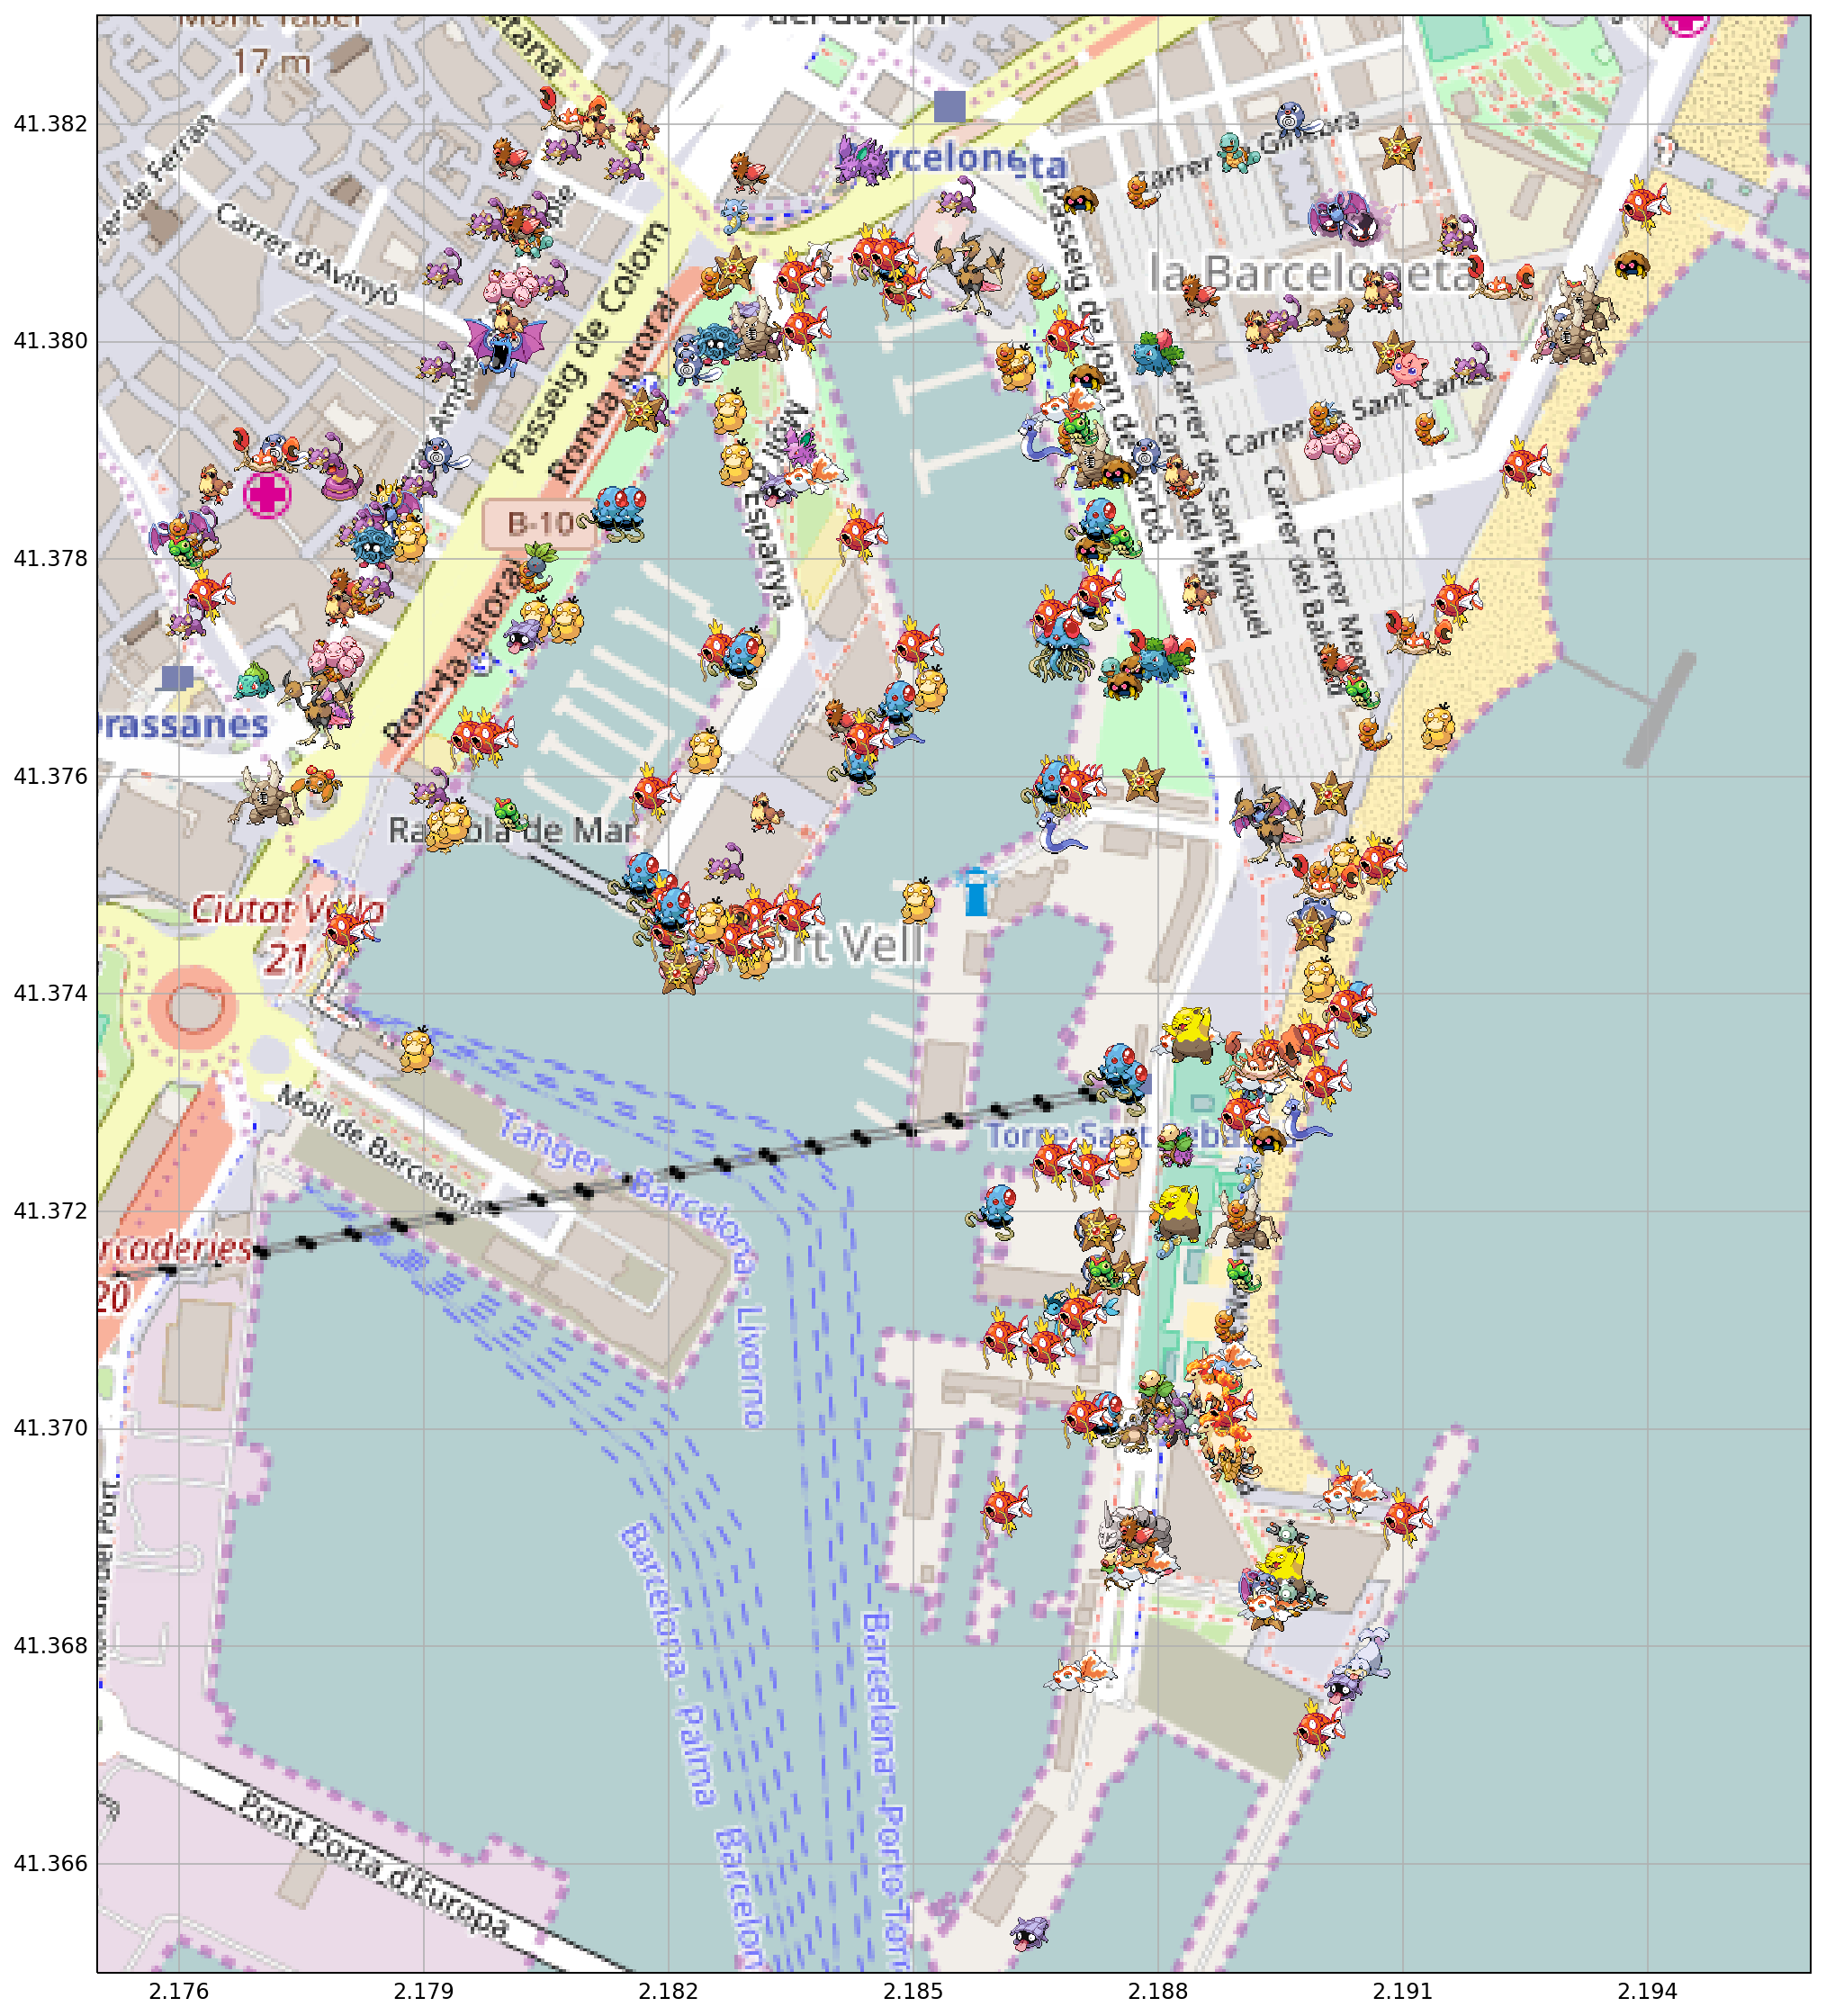

CPU times: user 3.66 s, sys: 263 ms, total: 3.92 s
Wall time: 13.9 s


In [20]:
%%time
with pd.HDFStore(filename, mode='r') as hdf:
    df2 = hdf.select(key='pokemons', where=barcelona_coords)
extent = (2.175, 2.196, 41.365, 41.383)
detail_level = 15
plot_pokemons(df2, extent, detail_level)

### Exercise 2

Plot pokemons in Central Park, New York.   

Tip: http://www.bufa.es/google-maps-latitud-longitud/

In [21]:
central_park_coords = "(latitude > 40.764) & (latitude < 40.786) & (longitude > -73.982) & (longitude < -73.96)"

In [22]:
with pd.HDFStore(filename, mode='r') as hdf:    
    df2 = hdf.select(key='pokemons', where=central_park_coords)

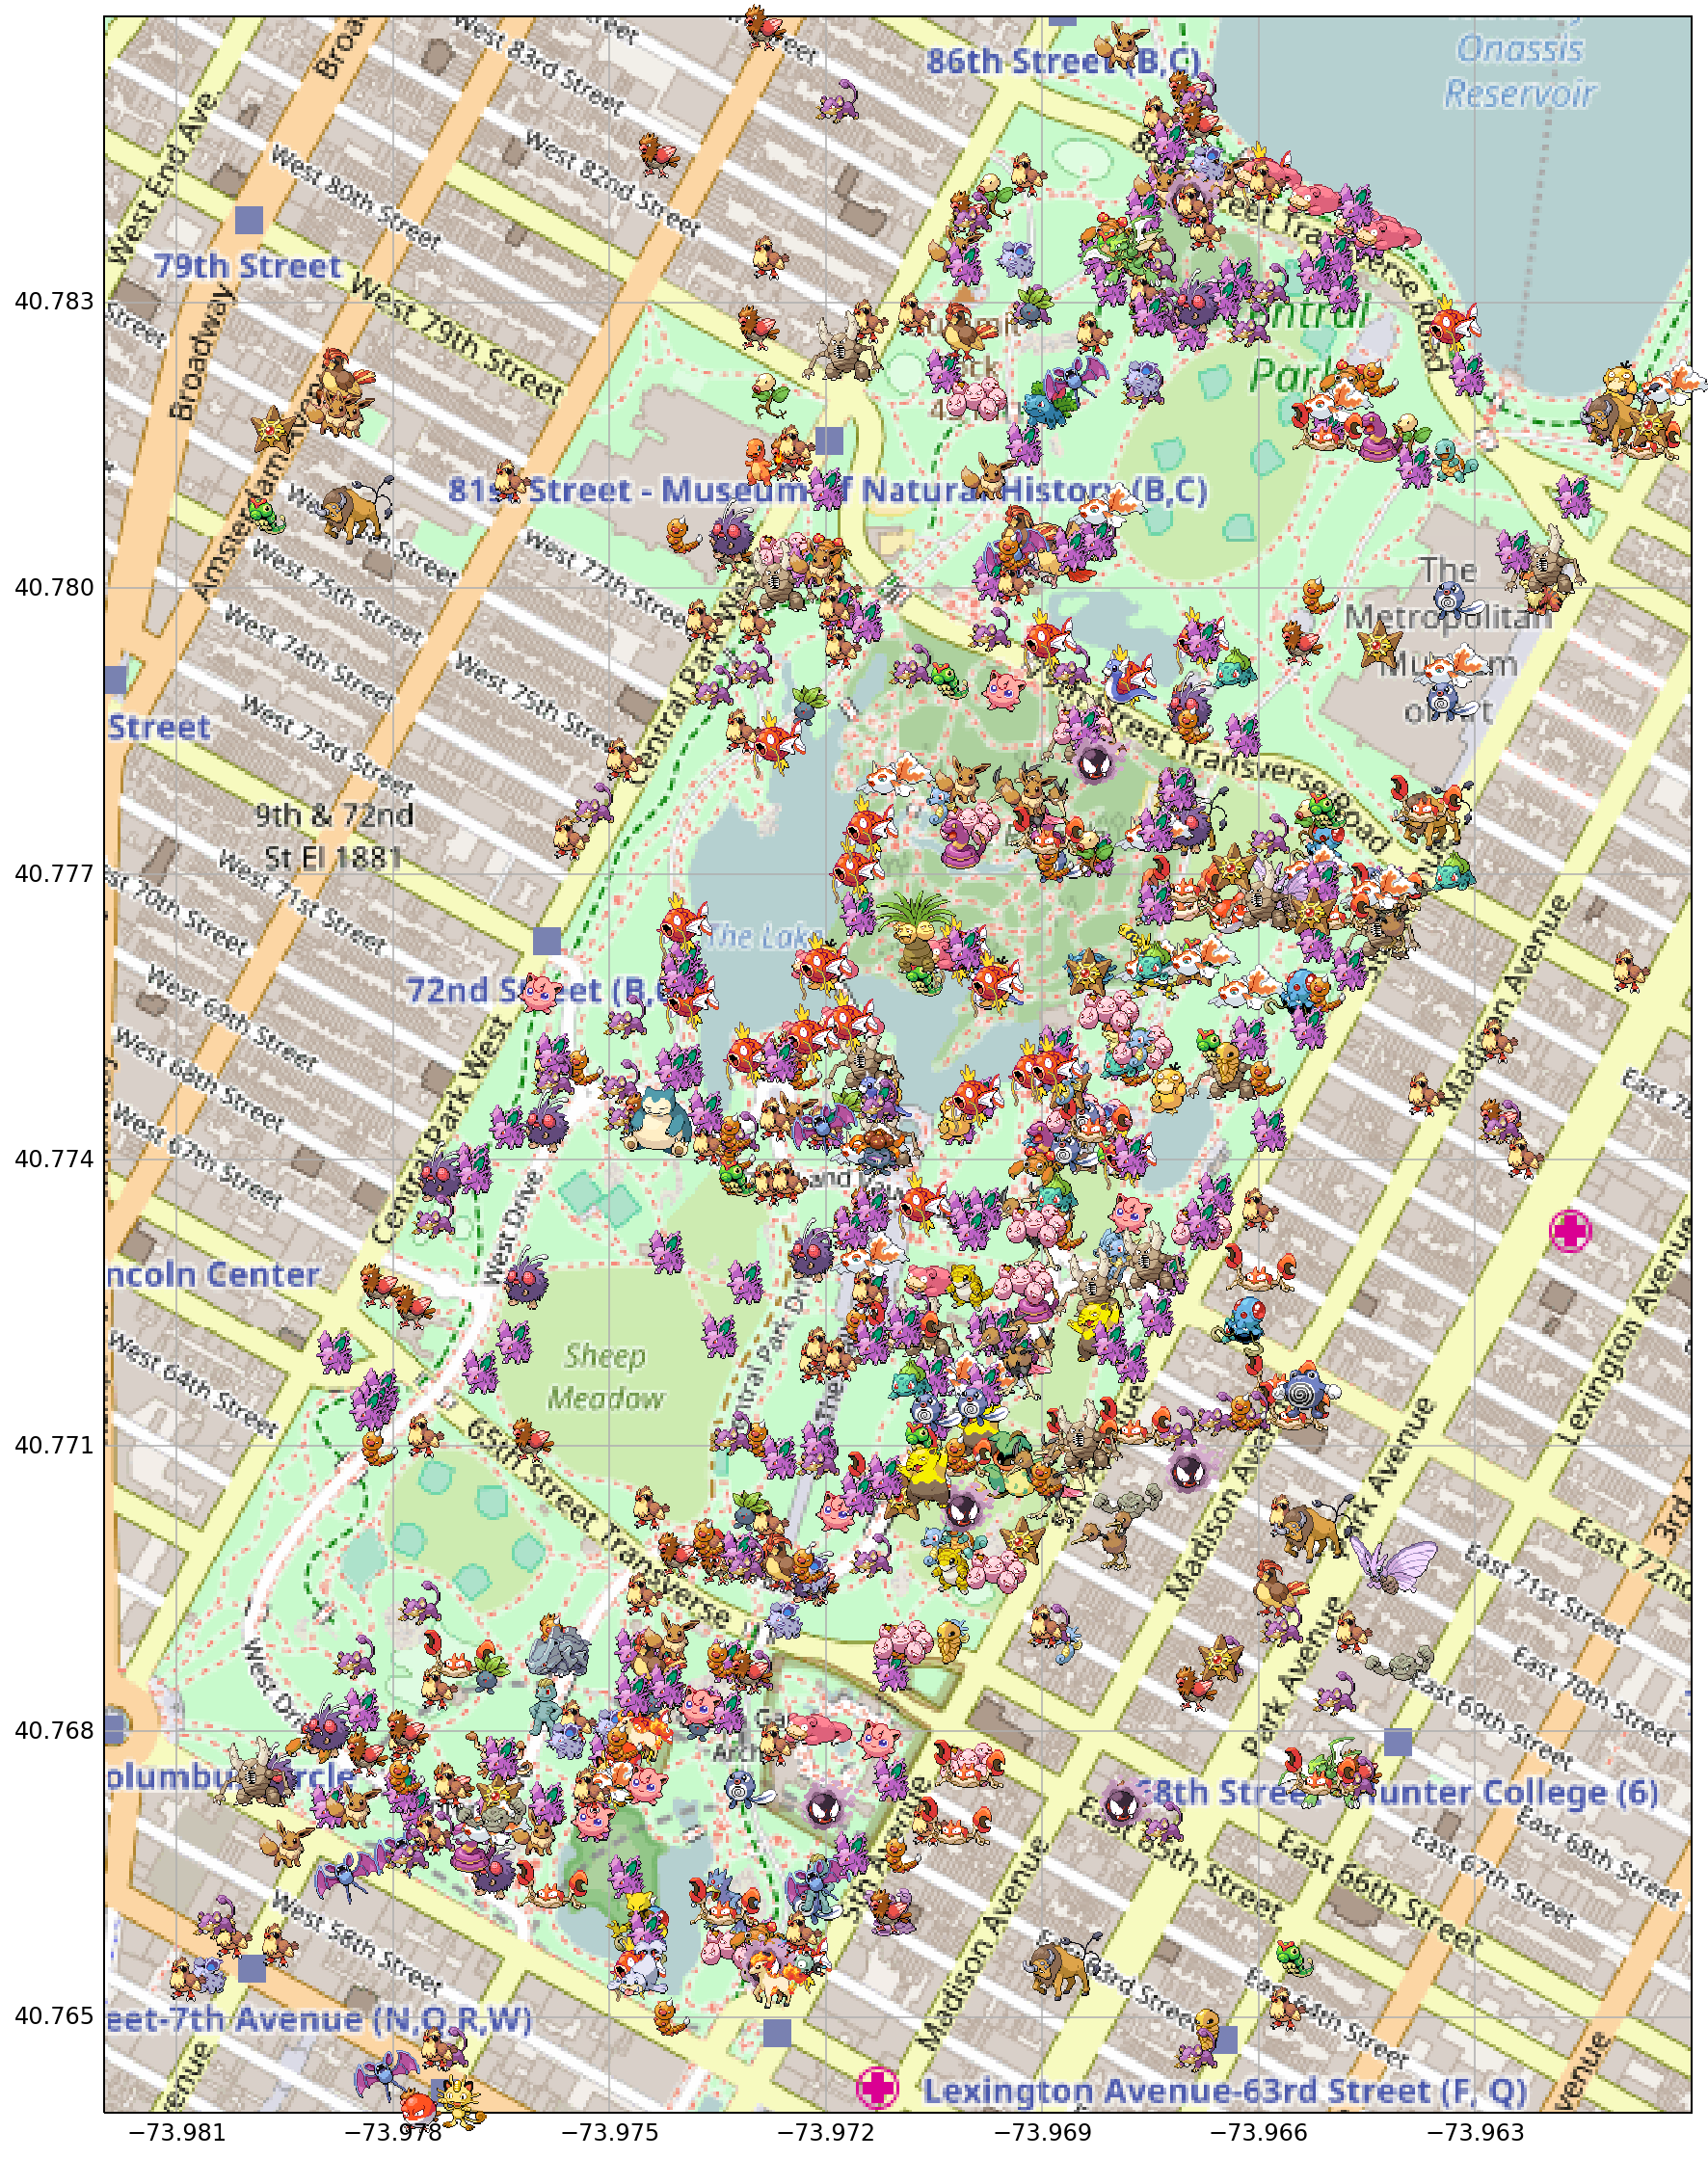

In [23]:
extent = (-73.982, -73.96, 40.764, 40.786)
detail_level = 15
plot_pokemons(df2, extent, detail_level)

### Exercise 3

There are some pokemon which are exclusive of certain regions; these are Farfetch'd (**target**=83), Kangashkan (**target**=115), Mr. Mime (**target**=122) and Tauros (**target**=128).  Plot the world map with only these pokemon.  

**Tip**: for plotting a world-wide view, copy the `plot_pokemons` function and replace the following lines: 

```python
tiler = cimgt.OSM()
fig, ax = plt.subplots(figsize=(25, 20), 
                       subplot_kw=dict(projection=tiler.crs))
# Grid and limits
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
ax.set_extent(extent)
# Tiler image and detail level
ax.add_image(tiler, detail_level) # always use low detail level during exploration
```

by

```python
fig, ax = fig, ax = plt.subplots(figsize=(25, 20), 
                           subplot_kw=dict(projection=ccrs.Mollweide()))
ax.stock_img()
```


In [24]:
with pd.HDFStore(filename, mode='r') as hdf: 
    df2 = hdf.select(key='pokemons', where='target=[122,128,115,83]')

In [25]:
def plot_pokemons(df, extent=None, detail_level=1, world_mode=False):
    
    if world_mode:
        fig, ax = fig, ax = plt.subplots(figsize=(25, 20), 
                           subplot_kw=dict(projection=ccrs.Mollweide()))
        ax.stock_img()
    else:
        tiler = cimgt.OSM()
        fig, ax = plt.subplots(figsize=(25, 20), 
                               subplot_kw=dict(projection=tiler.crs))
        # Grid and limits
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        ax.set_extent(extent)
        # Tiler image and detail level
        ax.add_image(tiler, detail_level) # always use low detail level during exploration
    # Point transformation from cartopy to matplotlib
    crs = ccrs.Geodetic()
    transform = crs._as_mpl_transform(ax)
    # Mapping points to Pokemon sprites
    x, y, targets = df.longitude.values, df.latitude.values, df.target.values
    artists = []
    for i in range(len(df)):
        image = plt.imread('pokemon/sprites/' + str(targets[i]) + '.png')
        im = OffsetImage(image, zoom=0.6)
        ab = AnnotationBbox(im, (x[i], y[i]), xycoords=transform, frameon=False)
        artists.append(ax.add_artist(ab))
    ax.plot(x, y, 'ob')

    plt.show()

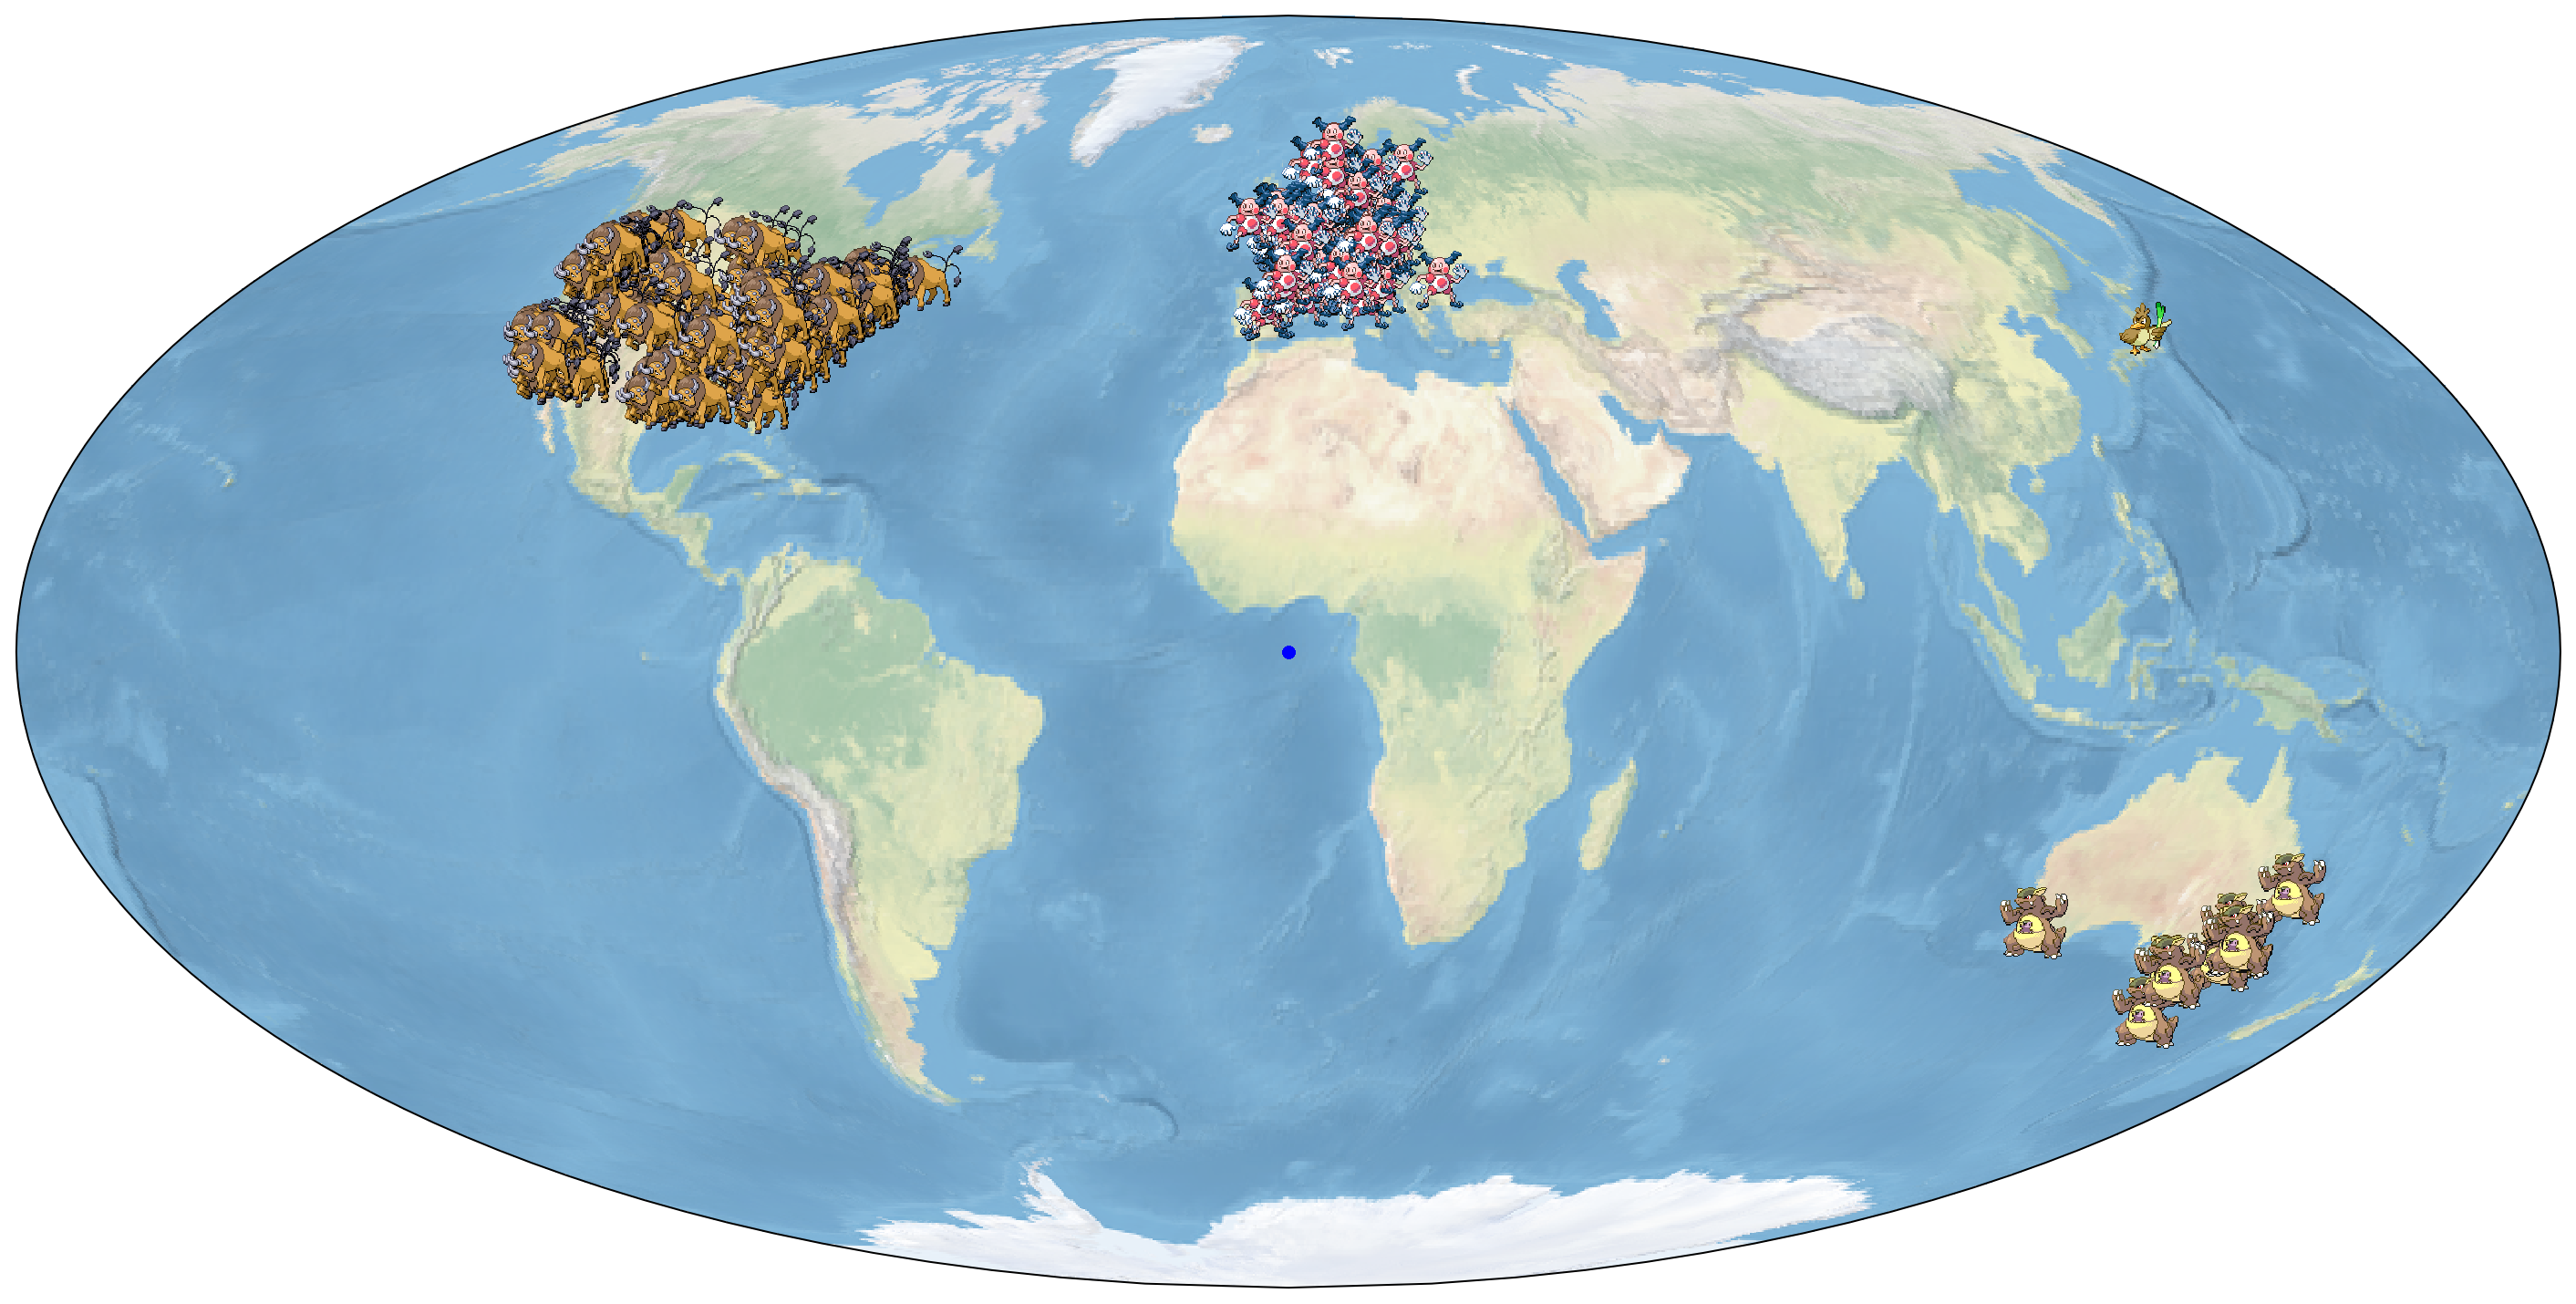

In [26]:
plot_pokemons(df2, world_mode=True)